# XMM-LSS master catalogue
## Preparation of Canada France Hawaii Telescope Lensing Survey (CFHTLenS) data

CFHTLenS catalogue: the catalogue comes from `dmu0_CFHTLenS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The kron magnitude, there doesn't appear to be aperture magnitudes. This may mean the survey is unusable.

We use the publication year 2012 for the epoch.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
91cdb7b (Fri Oct 20 11:48:11 2017 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "cfhtlens_ra"
DEC_COL = "cfhtlens_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'id': "cfhtlens_id",
        'ALPHA_J2000': "cfhtlens_ra",
        'DELTA_J2000': "cfhtlens_dec",
        'CLASS_STAR':  "cfhtlens_stellarity",
        'MAG_u': "m_cfhtlens_u",
        'MAGERR_u': "merr_cfhtlens_u",
        'MAG_g': "m_cfhtlens_g",
        'MAGERR_g': "merr_cfhtlens_g",
        'MAG_r': "m_cfhtlens_r",
        'MAGERR_r': "merr_cfhtlens_r",
        'MAG_i': "m_cfhtlens_i",
        'MAGERR_i': "merr_cfhtlens_i",
        'MAG_z': "m_cfhtlens_z",
        'MAGERR_z': "merr_cfhtlens_z",

    })


catalogue = Table.read("../../dmu0/dmu0_CFHTLenS/data/CFHTLenS_XMM-LSS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2012 #Year of publication

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        

        catalogue[col][catalogue[col] <= 0] = np.nan
        catalogue[errcol][catalogue[errcol] <= 0] = np.nan  
        catalogue[col][catalogue[col] > 90.] = np.nan
        catalogue[errcol][catalogue[errcol] > 90.] = np.nan         

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # We add nan filled aperture photometry for consistency
        catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="m_ap{}".format(col[1:])))
        catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="merr_ap{}".format(col[1:])))
        catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="f_ap{}".format(col[1:])))
        catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="f_err{}".format(col[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


In [6]:
catalogue[:10].show_in_notebook()

idx,cfhtlens_id,cfhtlens_ra,cfhtlens_dec,cfhtlens_stellarity,m_cfhtlens_u,merr_cfhtlens_u,m_cfhtlens_g,merr_cfhtlens_g,m_cfhtlens_r,merr_cfhtlens_r,m_cfhtlens_i,merr_cfhtlens_i,m_cfhtlens_z,merr_cfhtlens_z,f_cfhtlens_u,ferr_cfhtlens_u,m_ap_cfhtlens_u,merr_ap_cfhtlens_u,f_ap_cfhtlens_u,f_err_cfhtlens_u,flag_cfhtlens_u,f_cfhtlens_g,ferr_cfhtlens_g,m_ap_cfhtlens_g,merr_ap_cfhtlens_g,f_ap_cfhtlens_g,f_err_cfhtlens_g,flag_cfhtlens_g,f_cfhtlens_r,ferr_cfhtlens_r,m_ap_cfhtlens_r,merr_ap_cfhtlens_r,f_ap_cfhtlens_r,f_err_cfhtlens_r,flag_cfhtlens_r,f_cfhtlens_i,ferr_cfhtlens_i,m_ap_cfhtlens_i,merr_ap_cfhtlens_i,f_ap_cfhtlens_i,f_err_cfhtlens_i,flag_cfhtlens_i,f_cfhtlens_z,ferr_cfhtlens_z,m_ap_cfhtlens_z,merr_ap_cfhtlens_z,f_ap_cfhtlens_z,f_err_cfhtlens_z,flag_cfhtlens_z
0,W1p2p3_26473,36.40753151,-4.536274433,0.863145,26.5368,0.0998,25.3427,0.0268,24.6037,0.0187,23.6706,0.0131,22.9731,0.0167,0.0881616,0.00810375,nan,nan,nan,nan,False,0.264801,0.00653628,nan,nan,nan,nan,False,0.523022,0.00900818,nan,nan,nan,nan,False,1.23526,0.0149041,nan,nan,nan,nan,False,2.34833,0.0361203,nan,nan,nan,nan,False
1,W1p2p3_26477,36.45466044,-4.536313271,0.413574,26.7454,0.1136,26.4616,0.0672,25.5826,0.0449,25.346,0.0532,nan,nan,0.0727512,0.00761192,nan,nan,nan,nan,False,0.0944844,0.00584797,nan,nan,nan,nan,False,0.212305,0.00877975,nan,nan,nan,nan,False,0.263997,0.0129356,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False
2,W1p2p3_26487,36.40284791,-4.536216939,0.364888,25.5337,0.0738,25.2651,0.0459,25.1934,0.0544,nan,nan,nan,nan,0.222085,0.0150956,nan,nan,nan,nan,False,0.28442,0.012024,nan,nan,nan,nan,False,0.303837,0.0152235,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False
3,W1p2p3_26498,36.41517579,-4.536199275,0.787612,24.1692,0.0152,23.8709,0.0096,23.6993,0.0102,23.0049,0.0086,22.5607,0.0122,0.780404,0.0109254,nan,nan,nan,nan,False,1.02716,0.00908211,nan,nan,nan,nan,False,1.20304,0.011302,nan,nan,nan,nan,False,2.28055,0.018064,nan,nan,nan,nan,False,3.43336,0.0385794,nan,nan,nan,nan,False
4,W1p2p3_26533,36.43168992,-4.536012003,0.481453,nan,nan,26.2087,0.0538,25.5554,0.0401,25.2092,0.0488,24.3969,0.0526,nan,nan,nan,nan,nan,nan,False,0.119267,0.00590987,nan,nan,nan,nan,False,0.217691,0.00804007,nan,nan,nan,nan,False,0.299447,0.0134591,nan,nan,nan,nan,False,0.632761,0.030655,nan,nan,nan,nan,False
5,W1p2p3_26547,36.44658613,-4.535954975,0.504122,nan,nan,26.783,0.1028,25.643,0.0499,24.819,0.0392,nan,nan,nan,nan,nan,nan,nan,nan,False,0.0702748,0.00665378,nan,nan,nan,nan,False,0.200817,0.00922946,nan,nan,nan,nan,False,0.428943,0.0154868,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False
6,W1p2p3_26555,36.44390904,-4.535817105,0.447025,nan,nan,nan,nan,26.1326,0.062,25.3245,0.0502,25.4057,0.1185,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,0.127926,0.00730511,nan,nan,nan,nan,False,0.269278,0.0124503,nan,nan,nan,nan,False,0.249873,0.0272718,nan,nan,nan,nan,False
7,W1p2p3_26580,36.49047122,-4.535699039,0.534953,24.7101,0.0237,24.2549,0.0118,23.5411,0.0089,22.9265,0.0077,22.2278,0.0091,0.474198,0.010351,nan,nan,nan,nan,False,0.721174,0.00783786,nan,nan,nan,nan,False,1.39175,0.0114084,nan,nan,nan,nan,False,2.45132,0.0173846,nan,nan,nan,nan,False,4.6653,0.0391018,nan,nan,nan,nan,False
8,W1p2p3_26586,36.39472622,-4.535648621,0.467111,25.9077,0.059,25.6377,0.036,25.5414,0.0423,24.8839,0.0381,24.5305,0.0612,0.157369,0.00855161,nan,nan,nan,nan,False,0.2018,0.00669111,nan,nan,nan,nan,False,0.220516,0.00859124,nan,nan,nan,nan,False,0.404055,0.0141788,nan,nan,nan,nan,False,0.5595,0.0315375,nan,nan,nan,nan,False
9,W1p2p3_26591,36.44182574,-4.535672461,0.679594,25.9091,0.0587,24.9718,0.0204,24.8055,0.0214,24.6346,0.0284,24.3456,0.048,0.157167,0.00849716,nan,nan,nan,nan,False,0.372632,0.00700142,nan,nan,nan,nan,False,0.43431,0.0085603,nan,nan,nan,nan,False,0.508347,0.013297,nan,nan,nan,nan,False,0.663376,0.0293276,nan,nan,nan,nan,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_cfhtlens_u', 
             'merr_cfhtlens_g', 
             'merr_cfhtlens_r', 
             'merr_cfhtlens_i',
             'merr_cfhtlens_z']
FLAG_NAME = 'cfhtlens_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 1901 sources.
The cleaned catalogue has 1901 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_XMM-LSS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

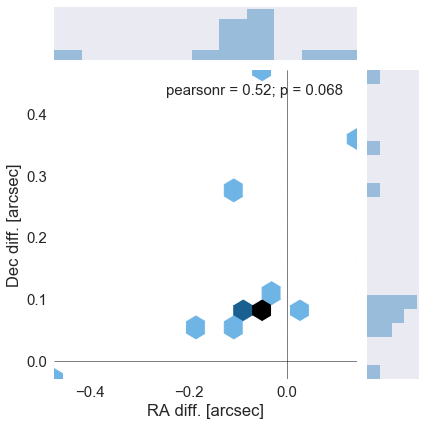

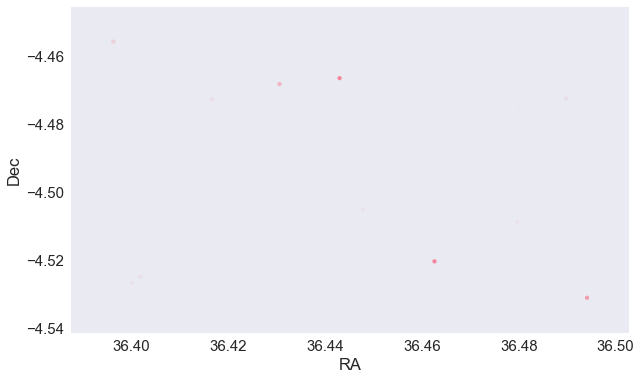

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.06234287111510639 arcsec
Dec correction: -0.08948011478651097 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

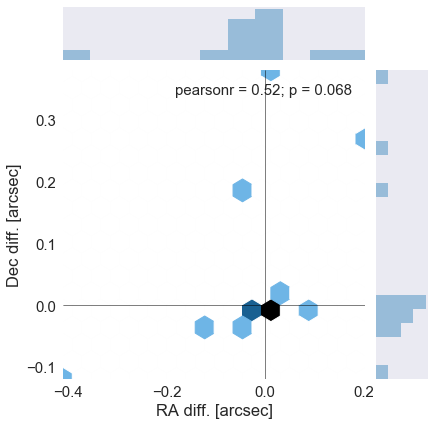

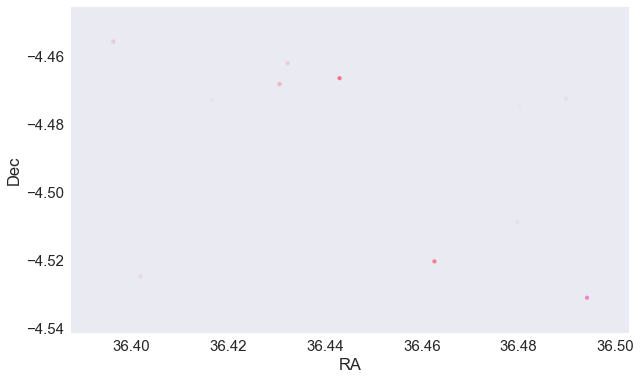

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "cfhtlens_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

14 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/CFHTLENS.fits".format(OUT_DIR), overwrite=True)